In [39]:
import random
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import logging
from datetime import datetime
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True

same_seeds(2022)
workspace_dir =  '.'

In [40]:
class FaceDataset(Dataset):
    def __init__(self, transform, file_names) :
        self.transform = transform
        self.fnames = file_names
        self.num_samples = len(self.fnames)
        
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img
    
    def __len__(self):
        return self.num_samples
    

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        # 标准化操作针对图像的每个通道（例如，对于彩色图像来说，就是红色通道、绿色通道和蓝色通道）进行。
        # transforms.Normalize 函数的 mean 和 std 参数表示用于标准化的值。
        # mean=(0.5, 0.5, 0.5) 和 std=(0.5, 0.5, 0.5) 表示每个通道的均值和标准差都设为 0.5。
        # 图像输入的RGB矩阵就是特征值，这里就是对特征值作标准化。
        transforms.Normalize(mean=(0.5, 0.5, 0.5),
                             std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = FaceDataset(transform, fnames)
    return dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


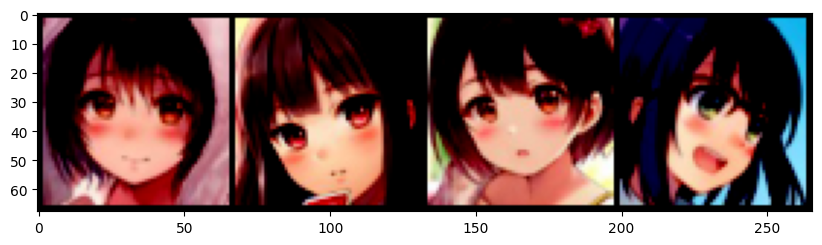

In [41]:
test_dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [test_dataset[i] for i in range(4)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [42]:
# setting for weight init function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [43]:
class Generator(nn.Module):

    def __init__(self, input_dim, feature_dim=64):
        super().__init__()

        self.Layer1 = nn.Sequential(
            nn.Linear(input_dim, feature_dim * 8 * 4 * 4 , bias=False),
            nn.BatchNorm2d(feature_dim * 8 * 4 * 4),
            nn.ReLU()
        )

        self.Layer2 = nn.Sequential(
            self.dconv_bn_relu(feature_dim * 8, feature_dim * 4),               #(batch, feature_dim * 16, 8, 8)     
            self.dconv_bn_relu(feature_dim * 4, feature_dim * 2),               #(batch, feature_dim * 16, 16, 16)     
            self.dconv_bn_relu(feature_dim * 2, feature_dim),  
        )

        self.Layer3 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, 3, kernel_size=5, stride=2,
                                padding=2, output_padding=1, bias=False),
            nn.Tanh()   
        )
        self.apply(weights_init)
    
    def dconv_bn_relu(self, in_dim, out_dim):
        return nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),        #double height and width
            nn.BatchNorm2d(out_dim),
            nn.ReLU(True)
        )
    
    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2(y)
        y = self.l3(y)
        return y

In [44]:
# Discriminator
class Discriminator(nn.Module):
    """
    Input shape: (batch, 3, 64, 64)
    Output shape: (batch)
    """
    def __init__(self, in_dim, feature_dim=64):
        super(Discriminator, self).__init__()
            
        #input: (batch, 3, 64, 64)
        """
        NOTE FOR SETTING DISCRIMINATOR:

        Remove last sigmoid layer for WGAN
        """
        self.l1 = nn.Sequential(
            nn.Conv2d(in_dim, feature_dim, kernel_size=4, stride=2, padding=1), #(batch, 3, 32, 32)
            nn.LeakyReLU(0.2),
            self.conv_bn_lrelu(feature_dim, feature_dim * 2),                   #(batch, 3, 16, 16)
            self.conv_bn_lrelu(feature_dim * 2, feature_dim * 4),               #(batch, 3, 8, 8)
            self.conv_bn_lrelu(feature_dim * 4, feature_dim * 8),               #(batch, 3, 4, 4)
            nn.Conv2d(feature_dim * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid() 
        )
        self.apply(weights_init)
    def conv_bn_lrelu(self, in_dim, out_dim):
        """
        NOTE FOR SETTING DISCRIMINATOR:

        You can't use nn.Batchnorm for WGAN-GP
        Use nn.InstanceNorm2d instead
        """

        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 4, 2, 1),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(0.2),
        )
    def forward(self, x):
        y = self.l1(x)
        y = y.view(-1)
        return y

In [45]:

class TrainerGAN():
    def __init__(self, config):
        self.config = config
        
        self.G = Generator(100)
        self.D = Discriminator(3)
        
        self.loss = nn.BCELoss()

        self.opt_D = torch.optim.Adam(self.D.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        self.opt_G = torch.optim.Adam(self.G.parameters(), lr=self.config["lr"], betas=(0.5, 0.999))
        
        self.dataloader = None
        self.log_dir = os.path.join(self.config["workspace_dir"], 'logs')
        self.ckpt_dir = os.path.join(self.config["workspace_dir"], 'checkpoints')
        
        FORMAT = '%(asctime)s - %(levelname)s: %(message)s'
        logging.basicConfig(level=logging.INFO, 
                            format=FORMAT,
                            datefmt='%Y-%m-%d %H:%M')
        
        self.steps = 0
        self.z_samples = Variable(torch.randn(100, self.config["z_dim"])).cuda()
        
    def prepare_environment(self):
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.ckpt_dir, exist_ok=True)
        
        # update dir by time
        time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        self.log_dir = os.path.join(self.log_dir, time+f'_{self.config["model_type"]}')
        self.ckpt_dir = os.path.join(self.ckpt_dir, time+f'_{self.config["model_type"]}')
        os.makedirs(self.log_dir)
        os.makedirs(self.ckpt_dir)
        
        # create dataset by the above function
        dataset = get_dataset(os.path.join(self.config["workspace_dir"], 'faces'))
        self.dataloader = DataLoader(dataset, batch_size=self.config["batch_size"], shuffle=True, num_workers=2)
        
        # model preparation
        self.G = self.G.cuda()
        self.D = self.D.cuda()
        self.G.train()
        self.D.train()
        
    def train(self):
      
        self.prepare_environment()
        
        for e, epoch in enumerate(range(self.config["n_epoch"])):
            
            progress_bar = tqdm(self.dataloader)
            progress_bar.set_description(f"Epoch {e+1}")
            
            for i, data in enumerate(progress_bar):
                imgs = data.cuda()
                bs = imgs.size(0)


                z = Variable(torch.randn(bs, self.config["z_dim"])).cuda()
                r_imgs = Variable(imgs).cuda()
                f_imgs = self.G(z)
                r_label = torch.ones((bs)).cuda()
                f_label = torch.zeros((bs)).cuda()



                r_logit = self.D(r_imgs)
                f_logit = self.D(f_imgs)


                r_loss = self.loss(r_logit, r_label)
                f_loss = self.loss(f_logit, f_label)
                loss_D = (r_loss + f_loss) / 2


                self.D.zero_grad()
                loss_D.backward()
                self.opt_D.step()



                if self.steps % self.config["n_critic"] == 0:
                    # Generate some fake images.
                    z = Variable(torch.randn(bs, self.config["z_dim"])).cuda()
                    f_imgs = self.G(z)

                    # Generator forwarding
                    f_logit = self.D(f_imgs)


                    # Loss for the generator.
                    loss_G = self.loss(f_logit, r_label)

                    # Generator backwarding
                    self.G.zero_grad()
                    loss_G.backward()
                    self.opt_G.step()
                    
                if self.steps % 10 == 0:
                    progress_bar.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())
                self.steps += 1

            self.G.eval()
            f_imgs_sample = (self.G(self.z_samples).data + 1) / 2.0
            filename = os.path.join(self.log_dir, f'Epoch_{epoch+1:03d}.jpg')
            torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
            logging.info(f'Save some samples to {filename}.')

            # Show some images during training.
            grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
            plt.figure(figsize=(10,10))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.show()

            self.G.train()

            if (e+1) % 5 == 0 or e == 0:
                # Save the checkpoints.
                torch.save(self.G.state_dict(), os.path.join(self.ckpt_dir, f'G_{e}.pth'))
                torch.save(self.D.state_dict(), os.path.join(self.ckpt_dir, f'D_{e}.pth'))

        logging.info('Finish training')

    def inference(self, G_path, n_generate=1000, n_output=30, show=False):
        """
        1. G_path is the path for Generator ckpt
        2. You can use this function to generate final answer
        """

        self.G.load_state_dict(torch.load(G_path))
        self.G.cuda()
        self.G.eval()
        z = Variable(torch.randn(n_generate, self.config["z_dim"])).cuda()
        imgs = (self.G(z).data + 1) / 2.0
        
        os.makedirs('output', exist_ok=True)
        for i in range(n_generate):
            torchvision.utils.save_image(imgs[i], f'output/{i+1}.jpg')
        
        if show:
            row, col = n_output//10 + 1, 10
            grid_img = torchvision.utils.make_grid(imgs[:n_output].cpu(), nrow=row)
            plt.figure(figsize=(row, col))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.show()
     
     

In [46]:

config = {
    "model_type": "GAN",
    "batch_size": 64,
    "lr": 1e-4,
    "n_epoch": 1,
    "n_critic": 1,
    "z_dim": 100,
    "workspace_dir": workspace_dir, # define in the environment setting
}

In [47]:

trainer = TrainerGAN(config)
trainer.train()

Epoch 1:   0%|          | 0/1115 [00:00<?, ?it/s]